In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService

from qiskit.quantum_info.operators import Operator, Pauli

from qiskit.circuit.library import UnitaryGate, QFT, RYGate, RealAmplitudes, HamiltonianGate


from qiskit.visualization import plot_histogram
import numpy as np
from math import cos,sin, pi, e, asin, log, factorial

%matplotlib inline

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum", token="77d55ab1f771f94f950d9a2ceddb5936a7d4f6a910a1fa73f2375c336af43585f40d831e221a3525bf57b651952f8a1e8ac7405b2f6319d1a5963288a69ef0c0")
QiskitRuntimeService.save_account(channel="ibm_quantum", token="77d55ab1f771f94f950d9a2ceddb5936a7d4f6a910a1fa73f2375c336af43585f40d831e221a3525bf57b651952f8a1e8ac7405b2f6319d1a5963288a69ef0c0", overwrite=True)

# HHL Genérico
Para implementar o HHL, necessitamos das entradas A e b e do número de bits de precisão que desejamos mapear o autovalores.

### Entrada:

In [76]:
# Exemplificando o caso mais simples
# A = N X N
# A vai ter que m e dar todas as possíveis codificações do autovalores
# 
A = np.matrix([[0.7093516035535562, 0.33732910457684684, 0.6860224778596967, 0.3410191011577089], 
               [0.33732910457684684, 0.864299872907477, 0.4009301841871931, 0.8625968813149048], 
               [0.6860224778596967, 0.4009301841871931, 0.6713965488630884, 0.4041282719467242], 
               [0.3410191011577089, 0.8625968813149048, 0.4041282719467242, 0.8609350772365953]])

# Testando A como um operador, QFT

N = 4

zeros = np.matrix([[0+0j, 0+0j, 0+0j, 0+0j],
                   [0+0j, 0+0j, 0+0j, 0+0j],
                   [0+0j, 0+0j, 0+0j, 0+0j],
                   [0+0j, 0+0j, 0+0j, 0+0j]])

A = np.matrix([[1, 1, 1, 1], 
               [1, np.exp(0+1j * 2 * np.pi / N)**(-1*1), np.exp(0+1j * 2 * np.pi / N)**(-1*2), np.exp(0+1j * 2 * np.pi / N)**(-1*3)], 
               [1, np.exp(0+1j * 2 * np.pi / N)**(-2*1), np.exp(0+1j * 2 * np.pi / N)**(-2*2), np.exp(0+1j * 2 * np.pi / N)**(-2*3)], 
               [1, np.exp(0+1j * 2 * np.pi / N)**(-3*1), np.exp(0+1j * 2 * np.pi / N)**(-3*2), np.exp(0+1j * 2 * np.pi / N)**(-3*3)]])

temp1 = np.concatenate((zeros, A), axis=0)
temp2 = np.concatenate((A.transpose().conjugate(), zeros), axis=0)

# b = log N 2
precision = 9

In [75]:
temp1

matrix([[ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j,
          1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j],
        [ 1.0000000e+00+0.0000000e+00j,  6.1232340e-17-1.0000000e+00j,
         -1.0000000e+00-1.2246468e-16j, -1.8369702e-16+1.0000000e+00j],
        [ 1.0000000e+00+0.0000000e+00j, -1.0000000e+00-1.2246468e-16j,
          1.0000000e+00+2.4492936e-16j, -1.0000000e+00-3.6739404e-16j],

In [78]:
temp2

matrix([[ 1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j,
          1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j],
        [ 1.0000000e+00-0.0000000e+00j,  6.1232340e-17+1.0000000e+00j,
         -1.0000000e+00+1.2246468e-16j, -1.8369702e-16-1.0000000e+00j],
        [ 1.0000000e+00-0.0000000e+00j, -1.0000000e+00+1.2246468e-16j,
          1.0000000e+00-2.4492936e-16j, -1.0000000e+00+3.6739404e-16j],
        [ 1.0000000e+00-0.0000000e+00j, -1.8369702e-16-1.0000000e+00j,
         -1.0000000e+00+3.6739404e-16j,  5.5109106e-16+1.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],

In [79]:
QFT_transp = np.concatenate((temp1, temp2), axis=1)
QFT_transp

matrix([[ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j,
          1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          1.0000000e+00-0.0000000e+00j,  6.1232340e-17+1.0000000e+00j,
         -1.0000000e+00+1.2246468e-16j, -1.8369702e-16-1.0000000e+00j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          1.0000000e+00-0.0000000e+00j, -1.0000000e+00+1.2246468e-16j,
          1.0000000e+00-2.4492936e-16j, -1.0000000e+00+3.6739404e-16j],
        [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
          0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
   

In [67]:
QFT().hamiltonian()

AttributeError: 'QFT' object has no attribute 'hamiltonian'

In [58]:
np.conjugate(np.transpose(A))

matrix([[ 1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j,
          1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j],
        [ 1.0000000e+00+0.0000000e+00j,  6.1232340e-17-1.0000000e+00j,
         -1.0000000e+00-1.2246468e-16j, -1.8369702e-16+1.0000000e+00j],
        [ 1.0000000e+00+0.0000000e+00j, -1.0000000e+00-1.2246468e-16j,
          1.0000000e+00+2.4492936e-16j, -1.0000000e+00-3.6739404e-16j],
        [ 1.0000000e+00+0.0000000e+00j, -1.8369702e-16+1.0000000e+00j,
         -1.0000000e+00-3.6739404e-16j,  5.5109106e-16-1.0000000e+00j]])

In [61]:
A

matrix([[ 1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j,
          1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j],
        [ 1.0000000e+00-0.0000000e+00j,  6.1232340e-17+1.0000000e+00j,
         -1.0000000e+00+1.2246468e-16j, -1.8369702e-16-1.0000000e+00j],
        [ 1.0000000e+00-0.0000000e+00j, -1.0000000e+00+1.2246468e-16j,
          1.0000000e+00-2.4492936e-16j, -1.0000000e+00+3.6739404e-16j],
        [ 1.0000000e+00-0.0000000e+00j, -1.8369702e-16-1.0000000e+00j,
         -1.0000000e+00+3.6739404e-16j,  5.5109106e-16+1.0000000e+00j]])

### Implementar U a partir da série de Taylor

In [7]:
def get_hamiltonian_from_taylor_series(A, t=1, steps=5):
    if steps == 0: return A
    H = np.identity(len(A))
    i=1
    for i in range(steps+1):
        if i%2==0:
            H = H - (np.dot(A, H)*t**i)/ factorial(i)
        else:
            H = H + (1j*np.dot(A, H)*t**i)/ factorial(i)

    return H

In [42]:
def get_list_hamiltonians_from_U(A, precision):
    U = A
    U_arrays = [U]
    for i in range(precision):
        U_arrays.append(np.dot(U, U))
    return U_arrays

H = get_list_hamiltonians_from_U(A, precision)
H

[matrix([[ 1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j,
           1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j],
         [ 1.0000000e+00+0.0000000e+00j,  6.1232340e-17-1.0000000e+00j,
          -1.0000000e+00-1.2246468e-16j, -1.8369702e-16+1.0000000e+00j],
         [ 1.0000000e+00+0.0000000e+00j, -1.0000000e+00-1.2246468e-16j,
           1.0000000e+00+2.4492936e-16j, -1.0000000e+00-3.6739404e-16j],
         [ 1.0000000e+00+0.0000000e+00j, -1.8369702e-16+1.0000000e+00j,
          -1.0000000e+00-3.6739404e-16j,  5.5109106e-16-1.0000000e+00j]]),
 matrix([[ 4.00000000e+00+0.00000000e+00j,
          -1.83697020e-16-2.22044605e-16j,
           0.00000000e+00-2.44929360e-16j,
           3.29046455e-16-3.33066907e-16j],
         [-1.83697020e-16-2.22044605e-16j,
           0.00000000e+00-2.44929360e-16j,
           3.17604077e-16-3.55951662e-16j,
           4.00000000e+00+1.46957616e-15j],
         [ 0.00000000e+00-2.44929360e-16j,
           3.17604077e-16-3.5

### Implementar U a partir da biblioteca do Qiskit

In [44]:
A

matrix([[ 1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j,
          1.0000000e+00+0.0000000e+00j,  1.0000000e+00+0.0000000e+00j],
        [ 1.0000000e+00+0.0000000e+00j,  6.1232340e-17-1.0000000e+00j,
         -1.0000000e+00-1.2246468e-16j, -1.8369702e-16+1.0000000e+00j],
        [ 1.0000000e+00+0.0000000e+00j, -1.0000000e+00-1.2246468e-16j,
          1.0000000e+00+2.4492936e-16j, -1.0000000e+00-3.6739404e-16j],
        [ 1.0000000e+00+0.0000000e+00j, -1.8369702e-16+1.0000000e+00j,
         -1.0000000e+00-3.6739404e-16j,  5.5109106e-16-1.0000000e+00j]])

In [80]:
U = HamiltonianGate(QFT_transp, 1, 'U')
U

Instruction(name='hamiltonian', num_qubits=3, num_clbits=0, params=[array([[ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j,
         1.0000000e+00-0.0000000e+00j,  1.0000000e+00-0.0000000e+00j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         1.0000000e+00-0.0000000e+00j,  6.1232340e-17+1.0000000e+00j,
        -1.0000000e+00+1.2246468e-16j, -1.8369702e-16-1.0000000e+00j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         1.0000000e+00-0.0000000e+00j, -1.0000000e+00+1.2246468e-16j,
         1.0000000e+00-2.4492936e-16j, -1.0000000e+00+3.6739404e-16j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e

In [28]:
U_array_qiskit = get_list_hamiltonians_from_U(U, precision)
U_array_qiskit

[Instruction(name='hamiltonian', num_qubits=2, num_clbits=0, params=[array([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]]), 1]),
 array([[ 0.71362499-0.24733956j, -0.28637501-0.24733956j,
         -0.28637501-0.24733956j, -0.28637501-0.24733956j],
        [-0.28637501-0.24733956j,  0.71362499-0.24733956j,
         -0.28637501-0.24733956j, -0.28637501-0.24733956j],
        [-0.28637501-0.24733956j, -0.28637501-0.24733956j,
          0.71362499-0.24733956j, -0.28637501-0.24733956j],
        [-0.28637501-0.24733956j, -0.28637501-0.24733956j,
         -0.28637501-0.24733956j,  0.71362499-0.24733956j]]),
 array([[ 0.71362499-0.24733956j, -0.28637501-0.24733956j,
         -0.28637501-0.24733956j, -0.28637501-0.24733956j],
        [-0.28637501-0.24733956j,  0.71362499-0.24733956j,
         -0.28637501-0.24733956j, -0.28637501-0.24733956j],
        [-0.28637501-0.24733956j, -0.2863

### Execução do QPE
Execução do QPE para conseguir os autovalores codificados nos bits

In [47]:
reg_qpe_clock = QuantumRegister(precision, name="clock")
reg_qpe_b = QuantumRegister(log(len(A), 2), name="b")
reg_qpe_classico = ClassicalRegister(precision)
circuit_qpe = QuantumCircuit(reg_qpe_clock, reg_qpe_b, reg_qpe_classico)

circuit_qpe.draw()


clock_0: 
         
clock_1: 
         
clock_2: 
         
clock_3: 
         
clock_4: 
         
clock_5: 
         
clock_6: 
         
clock_7: 
         
clock_8: 
         
    b_0: 
         
    b_1: 
         
   c6: 9/

### Especificação dos registradores do circuito:

In [22]:
reg_hhl_ancilla = QuantumRegister(1, name="ancilla")
reg_hhl_clock = QuantumRegister(precision, name="clock")
reg_hhl_b = QuantumRegister(log(len(A),2), name="b")
reg_hhl_ancilla_classico = ClassicalRegister(1)
reg_hhl_classico = ClassicalRegister(log(len(A),2))
circuit_hhl = QuantumCircuit(reg_hhl_ancilla, reg_hhl_clock, reg_hhl_b, reg_hhl_ancilla_classico, reg_hhl_classico)

%matplotlib inline

circuit_hhl.draw()

ancilla: 
         
clock_0: 
         
clock_1: 
         
clock_2: 
         
clock_3: 
         
clock_4: 
         
clock_5: 
         
clock_6: 
         
clock_7: 
         
clock_8: 
         
    b_0: 
         
    b_1: 
         
   c2: 1/
         
   c3: 2/

### Função de decomposição clássica:
Essa função decompõe a matriz de entrada A, aplicando um diagonalização para fim de testes, ela retorna uma matriz diagonal W com autovalores e V, com autovetores. 

Retorna também uma lista dos autovalores ajustados. 

In [13]:
def get_classic_decomposition(A):
    w,v = np.linalg.eig(A)

    print(w)
    print(v)

    cols = A.shape[0]

    # 
    A_lambda = []
    # print(A_lambda)
    for i in range(cols):
        A_lambda.append(round(w[i]/min(w)))
    
    A_lambda.sort()
    return v, w, A_lambda
    

v, w, lmb = get_classic_decomposition(A)
# print(lmb)
min(w)

[2.31336091e+00 7.92614347e-01 6.40096727e-06 1.44746429e-06]
[[ 0.4270703   0.60217906  0.59490053 -0.31793819]
 [ 0.55421202 -0.4404264  -0.29501955 -0.64174535]
 [ 0.45028617  0.50525675 -0.65199692  0.34184499]
 [ 0.55470926 -0.43372868  0.36600115  0.60845725]]


1.4474642912019747e-06

### Monta o _array_ com todos os U's necessários de acordo com a precisão:

In [14]:
def get_t(w, lmb):
    return (lmb[0]*2*pi)/(min(w)*2**(precision))
    
def get_classic_U(v, w):
    U_array = []

    cols = w.shape[0]

    U = np.zeros((cols, cols), dtype=np.complex_)
    t = get_t(w, lmb)
    print(U)

    for i in range(precision):
        if i ==0:
            for j in range(cols):
                print(j)
                U[j, j] = e**(1j*w[j]*t)
        else:
            U = np.dot(U, U) 
        U_array.append(np.dot(np.dot(v.transpose(),U),v))

    
    print(U_array)
    return U_array

# U_array = get_classic_U(v, w)

### QPE original

In [15]:
reg_qpe_b.size

2

In [16]:
def make_u(matrix,i=0, inverse=False):
    if inverse:
        u = Operator(np.linalg.inv(matrix))
    
        gate = UnitaryGate(u, label=f"Uˆ{2**i}")
    else:
        u = Operator(matrix)
    
        gate = UnitaryGate(u, label=f"Uˆ{2**i}")
    return gate


def qpe(circuit, U_array, reg_clock, reg_b, precision, inverse=False):
    if inverse:
        for i in range(precision):
            circuit.append(make_u(U_array[precision-i-1], precision-i-1, inverse=inverse).control(1), [reg_clock[i]] + [reg_b[j] for j in range(reg_b.size)])

        circuit.h(reg_clock)
    else:
        circuit.h(reg_qpe_clock)

        for i in range(precision):
            circuit.append(make_u(U_array[i], i).control(1), [reg_clock[i]] + [reg_b[j] for j in range(reg_b.size)])

    
    circuit.draw()

# qpe(circuit, U_array, precision)
# circuit.draw()

### Rotações controladas

In [17]:
reg_hhl_ancilla

QuantumRegister(1, 'ancilla')

In [18]:
def rotacoes_controladas(circuit, reg_clock, reg_ancilla, lmb, precision):
    for i in lmb:
        print(i)
        print(bin(i)[2:].zfill(precision))
        # if (len(bin(i)[2:]) > precision):
        #     raise Exception("""
        #     O número necessário de bits para representar autovalores excede o número de bits de precisão.
        #     Precisão: """ + """str(precision) """+ 
        #     """Registrador de clock: """ + str(len(bin(i)[2:])))
        circuit.append(RYGate(2*asin(1/i)).control(precision, ctrl_state=bin(i)[2:2+precision].zfill(precision)), [reg_clock[j] for j in range(precision)] + [reg_ancilla])

# rotacoes_controladas(circuit, lmb, precision)
# circuit.draw()

In [19]:
v, w, lmb = get_classic_decomposition(A)
U_array = get_classic_U(v, w)


# U_array = get_list_hamiltonians_from_U(HamiltonianGate(A, 1, 'U'), precision)

qpe(circuit_qpe, U_array, reg_qpe_clock, reg_qpe_b, precision)
circuit_qpe.append(QFT(precision,inverse=True),reg_qpe_clock)
circuit_qpe.measure(reg_qpe_clock, reg_qpe_classico)
circuit_qpe.draw()

[2.31336091e+00 7.92614347e-01 6.40096727e-06 1.44746429e-06]
[[ 0.4270703   0.60217906  0.59490053 -0.31793819]
 [ 0.55421202 -0.4404264  -0.29501955 -0.64174535]
 [ 0.45028617  0.50525675 -0.65199692  0.34184499]
 [ 0.55470926 -0.43372868  0.36600115  0.60845725]]
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
0
1
2
3
[matrix([[ 2.19307497e-02-1.93669244e-02j,
         -2.54981495e-02-3.97232615e-03j,
         -1.79629419e-01-3.06194084e-02j,
          9.81478322e-01+4.44303611e-02j],
        [-2.54981495e-02-3.97232615e-03j,
         -1.11480932e-01-3.03213791e-02j,
         -9.73852819e-01-6.25633124e-02j,
         -1.83206280e-01+1.08930587e-02j],
        [-1.79629419e-01-3.06194084e-02j,
         -9.73852819e-01-6.25633124e-02j,
          1.19391462e-01-1.54053444e-02j,
         -7.71818301e-04-3.42879406e-05j],
        [ 9.81478322e-01+4.44303611e-02j,
         -1.83206280e-01+1.08930587e-02j,
        

┌───┐                                                           »
clock_0: ┤ H ├───■───────────────────────────────────────────────────────»
         ├───┤   │                                                       »
clock_1: ┤ H ├───┼───────■───────────────────────────────────────────────»
         ├───┤   │       │                                               »
clock_2: ┤ H ├───┼───────┼───────■───────────────────────────────────────»
         ├───┤   │       │       │                                       »
clock_3: ┤ H ├───┼───────┼───────┼───────■───────────────────────────────»
         ├───┤   │       │       │       │                               »
clock_4: ┤ H ├───┼───────┼───────┼───────┼────────■──────────────────────»
         ├───┤   │       │       │       │        │                      »
clock_5: ┤ H ├───┼───────┼───────┼───────┼────────┼────────■─────────────»
         ├───┤   │       │       │       │        │        │             »
clock_6: ┤ H ├───┼───────┼───────┼───────┼────────┼────────┼────────■────»
         ├───┤   │       │       │       │        │        │        │    »
clock_7: ┤ H ├───┼───────┼───────┼───────┼────────┼────────┼────────┼────»
         ├───┤   │       │       │       │        │        │        │    »
clock_8: ┤ H ├───┼───────┼───────┼───────┼────────┼────────┼────────┼────»
         └───┘┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐┌───┴───┐┌───┴───┐┌───┴───┐»
    b_0: ─────┤0     ├┤0     ├┤0     ├┤0     ├┤0      ├┤0      ├┤0      ├»
              │  Uˆ1 ││  Uˆ2 ││  Uˆ4 ││  Uˆ8 ││  Uˆ16 ││  Uˆ32 ││  Uˆ64 │»
    b_1: ─────┤1     ├┤1     ├┤1     ├┤1     ├┤1      ├┤1      ├┤1      ├»
              └──────┘└──────┘└──────┘└──────┘└───────┘└───────┘└───────┘»
   c0: 9/════════════════════════════════════════════════════════════════»
                                                                         »
«                             ┌───────┐┌─┐                        
«clock_0: ────────────────────┤0      ├┤M├────────────────────────
«                             │       │└╥┘┌─┐                     
«clock_1: ────────────────────┤1      ├─╫─┤M├─────────────────────
«                             │       │ ║ └╥┘┌─┐                  
«clock_2: ────────────────────┤2      ├─╫──╫─┤M├──────────────────
«                             │       │ ║  ║ └╥┘┌─┐               
«clock_3: ────────────────────┤3      ├─╫──╫──╫─┤M├───────────────
«                             │       │ ║  ║  ║ └╥┘┌─┐            
«clock_4: ────────────────────┤4 IQFT ├─╫──╫──╫──╫─┤M├────────────
«                             │       │ ║  ║  ║  ║ └╥┘┌─┐         
«clock_5: ────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├─────────
«                             │       │ ║  ║  ║  ║  ║ └╥┘┌─┐      
«clock_6: ────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├──────
«                             │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
«clock_7: ────■───────────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├───
«             │               │       │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
«clock_8: ────┼─────────■─────┤8      ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├
«         ┌───┴────┐┌───┴────┐└───────┘ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
«    b_0: ┤0       ├┤0       ├──────────╫──╫──╫──╫──╫──╫──╫──╫──╫─
«         │  Uˆ128 ││  Uˆ256 │          ║  ║  ║  ║  ║  ║  ║  ║  ║ 
«    b_1: ┤1       ├┤1       ├──────────╫──╫──╫──╫──╫──╫──╫──╫──╫─
«         └────────┘└────────┘          ║  ║  ║  ║  ║  ║  ║  ║  ║ 
«   c0: 9/══════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩═
«                                       0  1  2  3  4  5  6  7  8

In [20]:
def hhl_generico(A, precision):
    v, w, lmb = get_classic_decomposition(A)

    U_array = get_classic_U(v, w)

    qpe(circuit_hhl, U_array, reg_hhl_clock, reg_hhl_b, precision)

    circuit_hhl.append(QFT(precision,inverse=True),reg_hhl_clock)

    rotacoes_controladas(circuit_hhl, reg_hhl_clock, reg_hhl_ancilla, lmb, precision)

    circuit_hhl.measure(reg_hhl_ancilla, reg_hhl_ancilla_classico)

    circuit_hhl.append(QFT(precision,inverse=False),reg_hhl_clock)

    qpe(circuit_hhl, U_array, reg_hhl_clock, reg_hhl_b, precision, inverse=True)

    circuit_hhl.measure(reg_hhl_b, reg_hhl_classico)

    circuit_hhl.draw()

    return circuit_hhl


In [21]:
circuit = hhl_generico(A, precision)

[2.31336091e+00 7.92614347e-01 6.40096727e-06 1.44746429e-06]
[[ 0.4270703   0.60217906  0.59490053 -0.31793819]
 [ 0.55421202 -0.4404264  -0.29501955 -0.64174535]
 [ 0.45028617  0.50525675 -0.65199692  0.34184499]
 [ 0.55470926 -0.43372868  0.36600115  0.60845725]]
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
0
1
2
3
[matrix([[ 2.19307497e-02-1.93669244e-02j,
         -2.54981495e-02-3.97232615e-03j,
         -1.79629419e-01-3.06194084e-02j,
          9.81478322e-01+4.44303611e-02j],
        [-2.54981495e-02-3.97232615e-03j,
         -1.11480932e-01-3.03213791e-02j,
         -9.73852819e-01-6.25633124e-02j,
         -1.83206280e-01+1.08930587e-02j],
        [-1.79629419e-01-3.06194084e-02j,
         -9.73852819e-01-6.25633124e-02j,
          1.19391462e-01-1.54053444e-02j,
         -7.71818301e-04-3.42879406e-05j],
        [ 9.81478322e-01+4.44303611e-02j,
         -1.83206280e-01+1.08930587e-02j,
        

In [22]:
circuit.draw()

»
ancilla: ────────────────────────────────────────────────────────────────»
         ┌───┐                                                           »
clock_0: ┤ H ├───■───────────────────────────────────────────────────────»
         ├───┤   │                                                       »
clock_1: ┤ H ├───┼───────■───────────────────────────────────────────────»
         ├───┤   │       │                                               »
clock_2: ┤ H ├───┼───────┼───────■───────────────────────────────────────»
         ├───┤   │       │       │                                       »
clock_3: ┤ H ├───┼───────┼───────┼───────■───────────────────────────────»
         ├───┤   │       │       │       │                               »
clock_4: ┤ H ├───┼───────┼───────┼───────┼────────■──────────────────────»
         ├───┤   │       │       │       │        │                      »
clock_5: ┤ H ├───┼───────┼───────┼───────┼────────┼────────■─────────────»
         ├───┤   │       │       │       │        │        │             »
clock_6: ┤ H ├───┼───────┼───────┼───────┼────────┼────────┼────────■────»
         ├───┤   │       │       │       │        │        │        │    »
clock_7: ┤ H ├───┼───────┼───────┼───────┼────────┼────────┼────────┼────»
         ├───┤   │       │       │       │        │        │        │    »
clock_8: ┤ H ├───┼───────┼───────┼───────┼────────┼────────┼────────┼────»
         └───┘┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐┌───┴───┐┌───┴───┐┌───┴───┐»
    b_0: ─────┤0     ├┤0     ├┤0     ├┤0     ├┤0      ├┤0      ├┤0      ├»
              │  Uˆ1 ││  Uˆ2 ││  Uˆ4 ││  Uˆ8 ││  Uˆ16 ││  Uˆ32 ││  Uˆ64 │»
    b_1: ─────┤1     ├┤1     ├┤1     ├┤1     ├┤1      ├┤1      ├┤1      ├»
              └──────┘└──────┘└──────┘└──────┘└───────┘└───────┘└───────┘»
   c1: 1/════════════════════════════════════════════════════════════════»
                                                                         »
   c2: 2/════════════════════════════════════════════════════════════════»
                                                                         »
«                                      ┌───────┐┌─────────────┐»
«ancilla: ─────────────────────────────┤ Ry(π) ├┤ Ry(0.50536) ├»
«                             ┌───────┐└───┬───┘└──────┬──────┘»
«clock_0: ────────────────────┤0      ├────■───────────o───────»
«                             │       │    │           │       »
«clock_1: ────────────────────┤1      ├────o───────────o───────»
«                             │       │    │           │       »
«clock_2: ────────────────────┤2      ├────o───────────■───────»
«                             │       │    │           │       »
«clock_3: ────────────────────┤3      ├────o───────────o───────»
«                             │       │    │           │       »
«clock_4: ────────────────────┤4 IQFT ├────o───────────o───────»
«                             │       │    │           │       »
«clock_5: ────────────────────┤5      ├────o───────────o───────»
«                             │       │    │           │       »
«clock_6: ────────────────────┤6      ├────o───────────o───────»
«                             │       │    │           │       »
«clock_7: ────■───────────────┤7      ├────o───────────o───────»
«             │               │       │    │           │       »
«clock_8: ────┼─────────■─────┤8      ├────o───────────o───────»
«         ┌───┴────┐┌───┴────┐└───────┘                        »
«    b_0: ┤0       ├┤0       ├─────────────────────────────────»
«         │  Uˆ128 ││  Uˆ256 │                                 »
«    b_1: ┤1       ├┤1       ├─────────────────────────────────»
«         └────────┘└────────┘                                 »
«   c1: 1/═════════════════════════════════════════════════════»
«                                                              »
«   c2: 2/═════════════════════════════════════════════════════»
«                                                              »
«         ┌──

# Execução dos circuitos

In [23]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Serviço de execução
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")

backend_noise = AerSimulator(noise_model=NoiseModel.from_backend(backend))
print(backend_noise)

from qiskit.providers.basic_provider import BasicSimulator

backend_sim = BasicSimulator()
print(backend)

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'x', 'sx', 'id', 'measure', 'ecr']>)
<IBMBackend('ibm_sherbrooke')>


In [24]:
def run_simulation(qc,shots=100000):    
    # Execute the circuit on the qasm simulator
    qc = transpile(qc, backend_sim)

    job_sim = backend_sim.run(qc, shots=shots)
    job_sim.wait_for_final_state(timeout=None, wait=5, callback=None)

    # Grab the results from the job.
    result_sim = job_sim.result()

    # Print the counts, which are contained in a Python dictionary
    counts = result_sim.get_counts(qc)

    return counts

    # sim_alpha = np.array([[counts.get("001",1)],[counts.get("011",1)],[counts.get("101",1)],[counts.get("111",1)]])

    # plot_histogram(counts)

    return sim_alpha

def run_noise_simulation(qc,shots=100000):    
    # Execute the circuit on the qasm simulator
    qc = transpile(qc, backend_noise)

    job_sim = backend_noise.run(qc, shots=shots)
    job_sim.wait_for_final_state(timeout=None, wait=5, callback=None)

    # Grab the results from the job.
    result_sim = job_sim.result()


    # Print the counts, which are contained in a Python dictionary
    counts = result_sim.get_counts()

    return counts

    # sim_alpha = np.array([[counts.get("001",1)],[counts.get("011",1)],[counts.get("101",1)],[counts.get("111",1)]])

    # plot_histogram(counts)

### 1) QPE

In [25]:
counts = run_simulation(circuit_qpe,shots=1000)
counts2 = run_noise_simulation(circuit_qpe,shots=1000)

In [26]:
# Autovalores reais
w

array([2.31336091e+00, 7.92614347e-01, 6.40096727e-06, 1.44746429e-06])

In [27]:
# Autovalores 
lmb

[1, 4, 547588, 1598216]

In [28]:
print(bin(lmb[0]))
print(bin(lmb[1]))
print(bin(lmb[2]))
print(bin(lmb[3]))

0b1
0b100
0b10000101101100000100
0b110000110001100001000


In [29]:
from operator import itemgetter

counts
res = dict(sorted(counts.items(), key=itemgetter(1), reverse=True)[:len(A)])
res


{'000000001': 303, '100000100': 263, '100001000': 168, '000000100': 116}

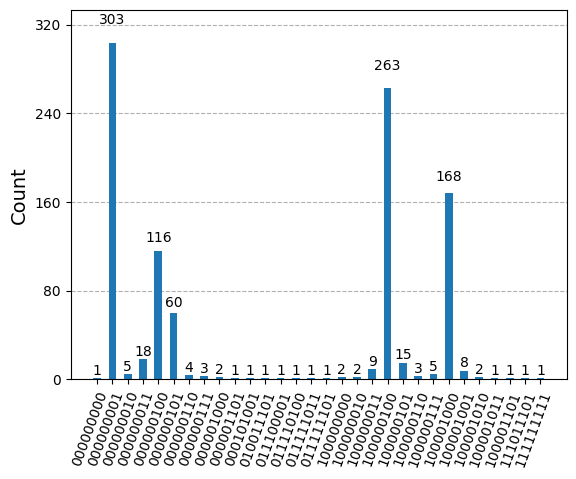

In [30]:
plot_histogram(counts)

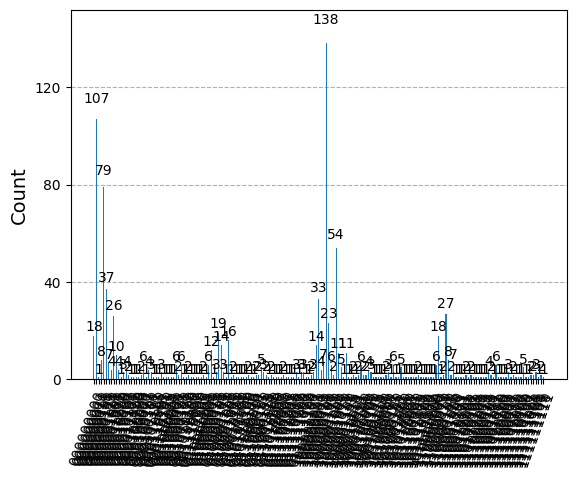

In [31]:
plot_histogram(counts2)

### 2) HHL

In [32]:
counts = run_simulation(circuit,shots=1000)
counts2 = run_noise_simulation(circuit,shots=1000)

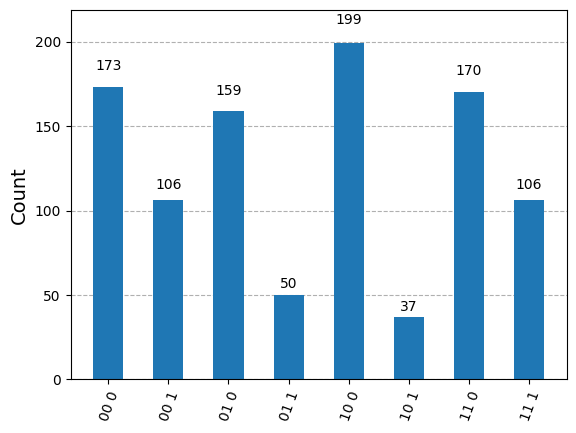

In [33]:
plot_histogram(counts)

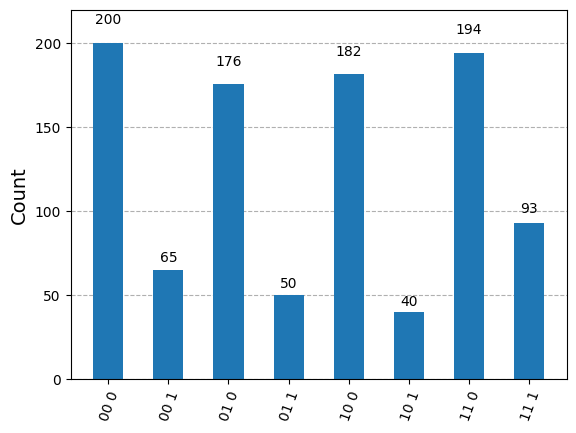

In [34]:
plot_histogram(counts2)

## Construindo QCL-QPE

In [35]:
# Criado o circuito